<a href="" target="_blank">
  <button style="background-color:#0072ce; color:white; padding:0.6em 1.2em; font-size:1rem; border:none; border-radius:6px; margin-top:1em;">
    🚀 Launch this notebook in JupyterLab
  </button>
</a>

### Introduction

falar sobre cheais em geral



<hr>

#### Import libraries

In [2]:
import xarray as xr 
import xarray_sentinel 
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np

<hr>

## Preparing the information to work with

To search and load the data we need for the analysis, we do a similar workflow as done before. For this Sentinel-1 GRD user case we are skipping those stpes. We start the analysis already knowing which product to use and the correct url to retrive the data.

Sentinel-1 GRD products store both VH and VV polarizations. For this flood mapping context, VV polarization is a better choice because water backscatter is much more visable with VV polarization rather than VH. Because of this, VH polarization will be discard right form the begginign of the analysis.

### Loading the datatree

The following list contains the names of each product that will be used for the flood mapping and time series analysis. These names alrady contain useful information (as we've learnt before on previous chapters) and can be use to search for specific products on the STAC catalog.

In [3]:
scenes = ["S1A_IW_GRDH_1SDV_20241007T180256_20241007T180321_056000_06D943_D46B", 
          "S1A_IW_GRDH_1SDV_20241019T180256_20241019T180321_056175_06E02E_2D52", 
          "S1A_IW_GRDH_1SDV_20241031T180256_20241031T180321_056350_06E71E_479F", 
          "S1A_IW_GRDH_1SDV_20241112T180255_20241112T180320_056525_06EE16_DC29", 
          "S1A_IW_GRDH_1SDV_20241124T180254_20241124T180319_056700_06F516_BA27", 
          "S1A_IW_GRDH_1SDV_20241206T180253_20241206T180318_056875_06FBFD_25AD", 
          "S1A_IW_GRDH_1SDV_20241218T180252_20241218T180317_057050_0702F2_0BC2", 
          "S1A_IW_GRDH_1SDV_20241230T180251_20241230T180316_057225_0709DD_15AC", 
          "S1A_IW_GRDH_1SDV_20250111T180250_20250111T180315_057400_0710C7_ADBB", 
          "S1A_IW_GRDH_1SDV_20250123T180249_20250123T180314_057575_0717B9_A784", 
          "S1A_IW_GRDH_1SDV_20250204T180249_20250204T180314_057750_071EA2_4373", 
          "S1A_IW_GRDH_1SDV_20250216T180248_20250216T180313_057925_0725AE_8AC7", 
          "S1A_IW_GRDH_1SDV_20250312T180248_20250312T180313_058275_0733E6_4F5B", 
          "S1A_IW_GRDH_1SDV_20250324T180248_20250324T180313_058450_073AD0_04B7", 
          "S1A_IW_GRDH_1SDV_20250405T180249_20250405T180314_058625_0741EA_248B", 
          "S1A_IW_GRDH_1SDV_20250417T180249_20250417T180314_058800_07490E_F868", 
          "S1A_IW_GRDH_1SDV_20250429T180249_20250429T180314_058975_07503A_10EA", 
          "S1A_IW_GRDH_1SDV_20250511T180249_20250511T180314_059150_0756D0_E613"
          ]

In [4]:
zarr_paths = []
for scene in scenes:
    zarr_paths.append(f"https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:notebook-data/tutorial_data/cpm_v260/{scene}.zarr")

In [5]:
datatrees = [xr.open_datatree(path, consolidated=True) for path in zarr_paths]

`datatrees` is a list containing lots of datatrees.

In [ ]:
type(datatrees) 

list

Each element inside the `datatree` list is a datatree and corresponds to a Sentinel-1 GRD scene datatree present on the list above.

In [20]:
type(datatrees[0]) 

xarray.core.datatree.DataTree

### Defining variables

In [21]:
# Number of scenes we are working with for the time series analysis
DATASET_NUMBER = len(datatrees) 

If you uncomment the following code line and run it, you'll see how each datatree is organized within its groups and subgroups (like seen on this [chapter](23_zarr_structure_S1GRD.ipynb)). From here, it was taken the groups ID constants seen on the following cell. Over the course of this notebook these IDs will be used to call variables and and compute some other functions.

In [19]:
# datatrees[0].groups

In [23]:
MEASUREMENTS_GROUP_ID = 7
GCP_GROUP_ID = 28
CALIBRATION_GROUP_ID = 33

We are also defining the thresholds which will be used for the flood mapping analysis. These values can be calibrated and adjusted to get a better fitting but generally water gets a positive backscatter response between -15 and -20.

In [22]:
WATER_THRESHOLD_DB = -15
OTHER_THRESHOLD_DB = -20

It is interesting to study the flood event over a specific point within the area of interest. Because of it we are storing the coordinates of a point chosen on an area which isn't usually covered by water but after the heavy rain, it got flooded for a few weeks. This is defenatly an interesting point for our times series analysis.

In [25]:
TARGET_LAT = 39.37
TARGET_LONG = -0.34

## Extracting information from the `.zarr`

Similar to what was done on the previous [chapters](24_S1_basic_operations.ipynb), we will perform over all our dataset some basic operations, such as:
- Slice the data to meet our area of interest and decimate it;
- Assigning latitude and longitude coordinates to the dataset;
- Compute the backscatter;

### Slicing and decimating GRD variable

We'll open all the dataset's `measurements` at the same time, creating a list storing all of them.

In [27]:
i = 0
measurements = []
while i < DATASET_NUMBER:
    measurements.append(datatrees[i][datatrees[i].groups[MEASUREMENTS_GROUP_ID]].to_dataset())
    i = i + 1

The same procedure will be applied for the `grd` subgroup. We will decimate the data (as done before) but also slice the data in other to crop the image to match our area of interest (Valencia area). 

Because we haven't assigned latitude and longitude coordinates yet, we can not crop the data acording to coordinates. On top of this, even though different products have the same shape and dimensions (`azimuth_time` and `ground_range`), the values for the same indexes number don't match so either ways, it wouldn't be doable to slice the data acording to coordinate values (which would always be differentfor different products).

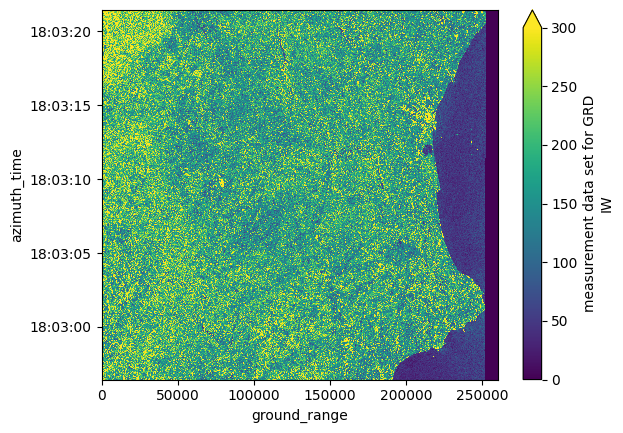

In [64]:
measurements[0].grd.isel(
        azimuth_time=slice(None, None, 20),
        ground_range=slice(None, None, 20)).plot(vmax=300)
plt.show()

In [60]:
print("Azimuth time has", measurements[0].grd.shape[0], "values.")
print("Ground range has", measurements[0].grd.shape[1], "values.")

Azimuth time has 16677 values.
Ground range has 26061 values.



The solution found is to slice the data by the coordinates index positon. Just before, a rought plotting was done in order to visualize the whole image. it was also plotted the `azimuth_time` and `ground_range` shape. Considering the are we are interested, and after a few tests and direct proportion calculations, we see that we need:
- for `azimuth_time`, more or less from the last 10000 positions to the last 4500;
- for `ground_range`, more or less from the last 7000 positions to the last 2000;

In [90]:
grd = []
for i in range(DATASET_NUMBER):
    grd_group = measurements[i].grd
    azimuth_time_len = grd_group.sizes['azimuth_time']
    ground_range_len = grd_group.sizes['ground_range']
    
    grd.append(grd_group.isel(
        azimuth_time=slice((azimuth_time_len - 10000),    # beginning of the slice
                           (azimuth_time_len - 4500),     # end of the slice
                           5),                           # interval of the slice/decimation
        ground_range=slice((ground_range_len - 7000), 
                           (ground_range_len - 2000), 
                           5)
    ))

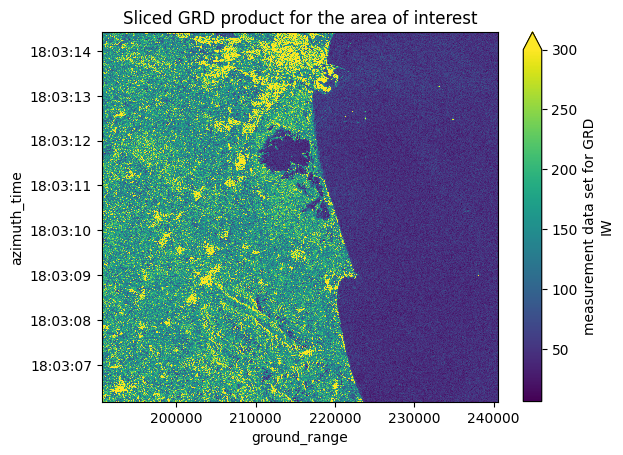

In [91]:
grd[1].plot(vmax=300)
plt.title("Sliced GRD product for the area of interest")
plt.show()

### Assigning latitude and longitude coordinates

The following steps will very similar to the ones done in the previous notebooks:
1. Creating a `gcp` dataset interpolated with the `grd` dataset;
2. Assigning the latitude and longitude coordinates to the `grd` dataset;

In [92]:
i = 0
gcp = []
while i < DATASET_NUMBER:
    gcp.append(datatrees[i][datatrees[i].groups[GCP_GROUP_ID]].to_dataset())
    gcp[i] = gcp[i].interp_like(grd[i])
    i = i + 1

In [93]:
i = 0
while i < DATASET_NUMBER:
    grd[i] = grd[i].assign_coords({"latitude": gcp[i].latitude, 
                                   "longitude": gcp[i].longitude})
    i = i + 1

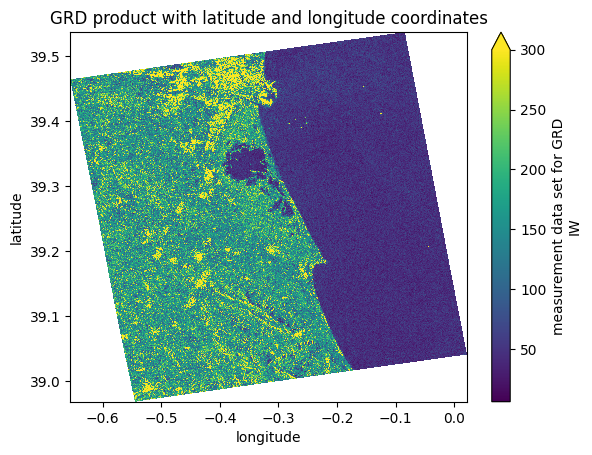

In [94]:
grd[1].plot(x="longitude", y="latitude", vmax=300)
plt.title("GRD product with latitude and longitude coordinates")
plt.show()

### Computing backscatter

Again, the following steps are just recreating what was done before, but this time over more datasets.

In [95]:
i = 0
calibration = []
while i < DATASET_NUMBER:
    calibration.append(datatrees[i][datatrees[i].groups[CALIBRATION_GROUP_ID]].to_dataset())
    gcp[i] = gcp[i].interp_like(grd[i])
    i = i + 1

In [96]:
i = 0
intensity = []
while i < DATASET_NUMBER:
    intensity.append(xarray_sentinel.calibrate_intensity(
        grd[i], 
        calibration[i].beta_nought, 
        as_db=True))
    i = i + 1

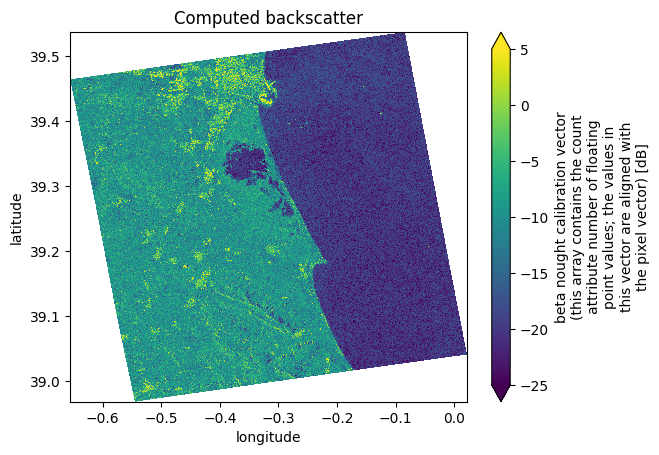

In [98]:
intensity[1].plot(x="longitude", y="latitude", vmin=-25, vmax=5)
plt.title("Computed backscatter")
plt.show()

### Data cube array for the times series analysis

In [101]:
i = 0
data = []
while i < DATASET_NUMBER:
    data.append(intensity[i].azimuth_time.values[1].astype('datetime64[D]'))
    i = i + 1

In [100]:
reference_coords = intensity[0].coords

datasets_aligned = []
for ds in intensity:
    ds_no_coords = ds.reset_coords(drop=True)
    datasets_aligned.append(ds_no_coords.assign_coords(reference_coords))

In [102]:
intensity_data_cube = xr.concat(
    datasets_aligned, 
    dim=xr.DataArray(data, dims="time"))

In [104]:
intensity_data_cube

<xarray.DataArray (time: 18, azimuth_time: 1100, ground_range: 1000)> Size: 79MB
array([[[ -8.361996 ,  -7.112641 , -11.859859 , ..., -17.391968 ,
         -14.527767 , -19.890743 ],
        [-12.004628 ,  -7.5822635, -11.647133 , ..., -16.368917 ,
         -16.4904   , -19.1955   ],
        [ -7.6704454,  -9.765152 , -12.687713 , ..., -19.364164 ,
         -16.738585 , -15.134006 ],
        ...,
        [ -9.9360285,  -5.249572 ,  -5.3847637, ..., -19.03005  ,
         -19.890743 , -20.26041  ],
        [-17.952541 ,  -9.4331665,  -6.6277213, ..., -19.03005  ,
         -21.050583 , -21.474365 ],
        [-13.1749   , -14.145908 , -10.973472 , ..., -21.919895 ,
         -19.536167 , -19.890743 ]],

       [[-12.37747  ,  -6.5106063,  -7.40854  , ..., -19.1955   ,
         -18.39807  , -24.267607 ],
        [ -9.821738 ,  -8.654805 , -12.847092 , ..., -18.247007 ,
         -20.846197 , -23.97314  ],
        [ -8.125308 ,  -5.661627 ,  -1.345046 , ..., -18.551805 ,
         -24.88829  , -25.2161   ],
...
         -18.708313 , -19.536167 ],
        [-12.453997 ,  -9.993742 , -13.343563 , ..., -20.646513 ,
         -17.667732 , -17.12469  ],
        [-12.226408 ,  -8.654805 ,  -6.2810106, ..., -18.247007 ,
         -15.785752 , -19.536167 ]],

       [[-11.038534 ,  -8.605313 , -13.2588215, ..., -22.151531 ,
         -23.97314  , -19.711645 ],
        [-10.531185 ,  -8.605313 ,  -6.3568697, ..., -20.073608 ,
         -18.867691 , -21.694275 ],
        [ -6.2810106,  -9.271814 ,  -6.0206003, ..., -19.890743 ,
         -18.551805 , -21.25989  ],
        ...,
        [ -7.112641 ,  -5.661627 ,  -4.8241887, ..., -20.646513 ,
         -21.474365 , -19.890743 ],
        [ -6.6671133,  -6.3950496,  -9.379049 , ..., -21.050583 ,
         -17.80897  , -19.711645 ],
        [ -5.4531555,  -6.866798 ,  -6.6277213, ..., -20.26041  ,
         -20.846197 , -17.391968 ]]],
      shape=(18, 1100, 1000), dtype=float32)
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 9kB 2024-10-07T18:03:06.46487...
  * ground_range  (ground_range) float64 8kB 1.906e+05 1.907e+05 ... 2.406e+05
    line          (azimuth_time) float64 9kB 6.677e+03 6.682e+03 ... 1.217e+04
    pixel         (ground_range) float64 8kB 1.906e+04 1.907e+04 ... 2.406e+04
    latitude      (azimuth_time, ground_range) float64 9MB 38.97 38.97 ... 39.54
    longitude     (azimuth_time, ground_range) float64 9MB -0.5476 ... -0.0871
  * time          (time) datetime64[s] 144B 2024-10-07 2024-10-19 ... 2025-05-11
Attributes:
    _eopf_attrs:  {'coordinates': ['azimuth_time', 'line', 'pixel', 'ground_r...
    dtype:        <u2
    long_name:    beta nought calibration vector (this array contains the cou...
    units:        dB

## Flood mapping and time series analysis

<hr>

## Challenges

- all data is not yet on the catalog so we have either to convert it (and run everything locally) or ask on eopf samples service

## Conclusion

os resultados das cheias, 